In [25]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import featuretools as ft
import lightgbm as lgb
from lightgbm import plot_tree
from graphviz import Digraph
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold,GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score,mean_squared_error
import category_encoders as ce
import time
import pickle
import gc
RSEED = 47

%matplotlib inline

# Load Data

In [5]:
with open('./data/df_train_total_feat.pickle', 'rb') as handle:
    df_train_total = pickle.load(handle)
    
with open('./data/df_test_total_feat.pickle', 'rb') as handle:
    df_test_total = pickle.load(handle)

In [6]:
df_train_total.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour
0,0,0,2016-01-01,0.0,0,0,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0
1,1,0,2016-01-01,0.0,0,0,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0
2,2,0,2016-01-01,0.0,0,0,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0
3,3,0,2016-01-01,0.0,0,0,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0
4,4,0,2016-01-01,0.0,0,0,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0


In [7]:
df_test_total.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour
0,0,0,0,2017-01-01,0,0,7432,2008.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6,0
1,1,1,0,2017-01-01,0,0,2720,2004.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6,0
2,2,2,0,2017-01-01,0,0,5376,1991.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6,0
3,3,3,0,2017-01-01,0,0,23685,2002.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6,0
4,4,4,0,2017-01-01,0,0,116607,1975.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6,0


# Remove Strange Data

In [8]:
df_train_total = df_train_total.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

# Add Feature

In [26]:
# change year built
df_train_total["year_built"] = df_train_total["timestamp"].dt.year - df_train_total["year_built"]
df_test_total["year_built"] = df_test_total["timestamp"].dt.year - df_test_total["year_built"]

In [27]:
# add weekday feature
# 3fold improve ele reduce others
df_train_total["weekday"] = df_train_total["timestamp"].dt.weekday
df_test_total["weekday"] = df_test_total["timestamp"].dt.weekday

In [28]:
df_train_total["month"] = df_train_total["timestamp"].dt.month
df_test_total["month"] = df_test_total["timestamp"].dt.month

In [140]:
# add target encoding feature
#df_group = df_train_total.groupby(['building_id','meter'])['meter_reading']
#building_median = df_group.median().astype(np.float16).to_frame().reset_index()
#df_train_total['building_median'] = df_train_total.groupby(['building_id','meter'])['meter_reading'].transform('median')
#df_test_total['building_median'] = pd.merge(df_test_total,building_median,on=['building_id','meter'],how='left')['meter_reading']

In [55]:
# log transform square feet
#df_train_total["square_feet"] = np.log(df_train_total["square_feet"])
#df_test_total["square_feet"] = np.log(df_test_total["square_feet"])

In [29]:
# drop useless feature
df_train_total.drop(["timestamp"],inplace = True,axis=1)
df_test_total.drop(["timestamp"],inplace = True,axis=1)

# Train with Seperate Meter Type

## General Settings

In [9]:
params = {'objective':'regression',
          'boosting_type':'gbdt',
          'metric':'rmse',
          'learning_rate':0.1,
          'num_leaves': 2**8,
          'max_depth':-1,
          'colsample_bytree':0.5,# feature_fraction 0.7
          'subsample_freq':1,
          'subsample':0.7,
          'verbose':-1,
          'num_threads':8,
          'seed': 47,#42
                } 

In [49]:
category_cols = ['building_id', 'site_id', 'primary_use'] #,'hour','weekday','month'
category_cols

['building_id', 'site_id', 'primary_use']

In [47]:
def fold_train_model(splits_num,features_train,labels_train,features_test,categorical):
    splits = splits_num
    folds = KFold(n_splits = splits,random_state=50)
    #folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=50)
    predictions = np.zeros(len(features_test))
    models = []
    ave_score = 0
    
    for fold_num, (trn_idx, val_idx) in enumerate(folds.split(features_train.values, labels_train.values)):
    #for fold_num, (trn_idx, val_idx) in enumerate(folds.split(features_train.values, features_train['building_id'])):
        print("Fold {}".format(fold_num))
        train_df, y_train_df = features_train.iloc[trn_idx], labels_train.iloc[trn_idx]
        valid_df, y_valid_df = features_train.iloc[val_idx], labels_train.iloc[val_idx]

        trn_data = lgb.Dataset(train_df, label=y_train_df,categorical_feature=categorical)
        val_data = lgb.Dataset(valid_df, label=y_valid_df,categorical_feature=categorical)

        valid_results = {}
        clf = lgb.train(params,
                        trn_data,
                        2000,#10000,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=500,
                        early_stopping_rounds=500,
                        evals_result=valid_results)

        pred = clf.predict(valid_df)
        score = np.sqrt(mean_squared_error(y_valid_df, pred))
        print(score)
        ave_score += score / splits
        predictions += np.expm1(clf.predict(features_test)) / splits
        models.append(clf)
    return ave_score,predictions,models

In [31]:
def train_meter_type(meter_type,df_train_total,df_test_total,category_cols,splits_num):
    # prepare data
    df_type_train = df_train_total[df_train_total.meter == meter_type]
    df_type_label = df_type_train['meter_reading']
    #df_type_label = np.log1p(df_type_train['meter_reading'])
    df_type_train.drop(columns = ['meter','meter_reading'],inplace=True)
    #df_type_train['timestamp'] = df_type_train['timestamp'].astype('int64') // 10**9

    df_type_test = df_test_total[df_test_total.meter == meter_type]
    df_type_row_id = df_type_test['row_id']
    df_type_test.drop(columns = ['row_id','meter'],inplace=True)
    #df_type_test['timestamp'] = df_type_test['timestamp'].astype('int64') // 10**9
    
    # train model
    print('train model')
    ave_score,predictions_type,models = fold_train_model(splits_num,df_type_train,df_type_label,df_type_test,category_cols)
    print('ave socre is %s'%(ave_score))
    
    # get prediction
    print('get prediction')
    sub_type = pd.DataFrame({'row_id': df_type_row_id, 'meter_reading': predictions_type})
    #sub_type = pd.DataFrame({'row_id': df_type_row_id, 'meter_reading': np.expm1(predictions_type)})
    return sub_type,ave_score,models

## Train electricity

In [50]:
sub_ele_f,ave_score,model_ele = train_meter_type(0,df_train_total,df_test_total,category_cols,3)

train model
Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.290268	valid_1's rmse: 0.57235
Early stopping, best iteration is:
[216]	training's rmse: 0.330168	valid_1's rmse: 0.57101
0.5710097630704873
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.269798	valid_1's rmse: 0.597484
[1000]	training's rmse: 0.239946	valid_1's rmse: 0.596412
[1500]	training's rmse: 0.222345	valid_1's rmse: 0.595816
[2000]	training's rmse: 0.210255	valid_1's rmse: 0.595901
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 0.210255	valid_1's rmse: 0.595901
0.5959011400877393
Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.285126	valid_1's rmse: 0.656954
Early stopping, best iteration is:
[174]	training's rmse: 0.33136	valid_1's rmse: 0.654381
0.6543811426049161
ave socre is 0.6070973485877142
get prediction


In [51]:
ave_score

0.6070973485877142

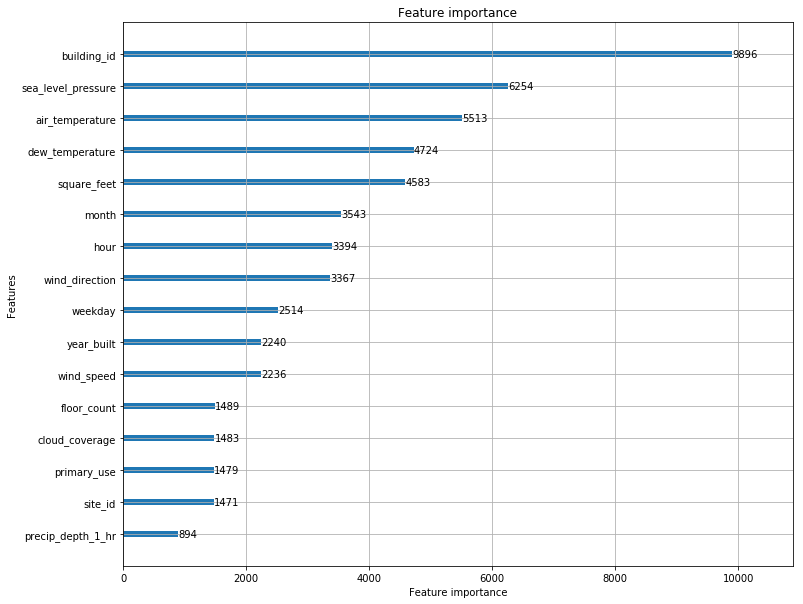

In [52]:
lgb.plot_importance(model_ele[0], max_num_features=20,figsize=(12,10))

In [53]:
sub_cw_f,ave_score_cw,model_cw = train_meter_type(1,df_train_total,df_test_total,category_cols,3)

train model
Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.659555	valid_1's rmse: 1.3664
Early stopping, best iteration is:
[414]	training's rmse: 0.677982	valid_1's rmse: 1.36285
1.3628521619864593
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.674033	valid_1's rmse: 1.3545
Early stopping, best iteration is:
[105]	training's rmse: 0.826399	valid_1's rmse: 1.34472
1.3447218183281489
Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.63732	valid_1's rmse: 1.60017
Early stopping, best iteration is:
[63]	training's rmse: 0.854995	valid_1's rmse: 1.52237
1.5223662605753767
ave socre is 1.4099800802966616
get prediction


In [54]:
ave_score_cw

1.4099800802966616

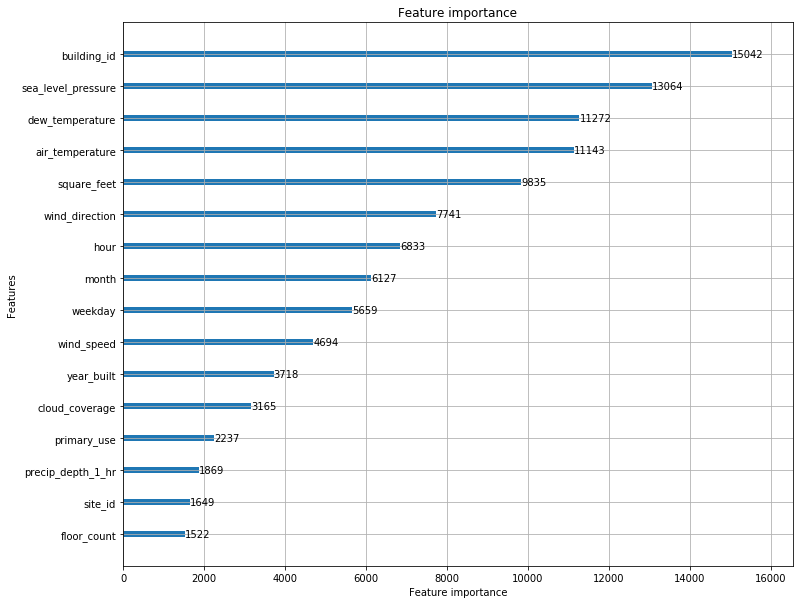

In [55]:
lgb.plot_importance(model_cw[0], max_num_features=20,figsize=(12,10))

In [56]:
sub_stm_f,ave_score_stm,model_stm = train_meter_type(2,df_train_total,df_test_total,category_cols,3)

train model
Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.83641	valid_1's rmse: 1.5826
Early stopping, best iteration is:
[53]	training's rmse: 1.04697	valid_1's rmse: 1.52755
1.5275511275092493
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.75442	valid_1's rmse: 1.48343
Early stopping, best iteration is:
[91]	training's rmse: 0.911384	valid_1's rmse: 1.47538
1.4753830641302736
Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.81669	valid_1's rmse: 1.5313
Early stopping, best iteration is:
[115]	training's rmse: 0.936448	valid_1's rmse: 1.51677
1.5167706566208876
ave socre is 1.50656828275347
get prediction


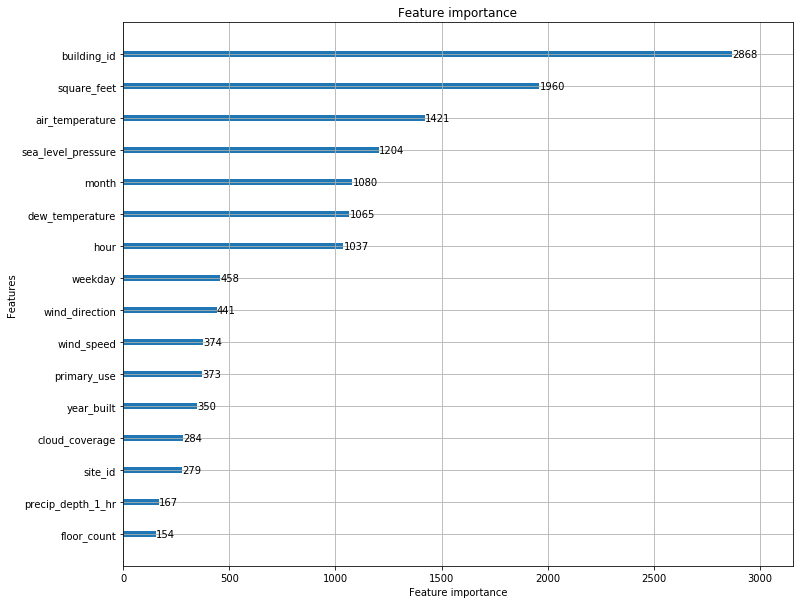

In [57]:
lgb.plot_importance(model_stm[0], max_num_features=20,figsize=(12,10))

In [58]:
sub_hw_f,ave_score_hw,model_hw = train_meter_type(3,df_train_total,df_test_total,category_cols,3)

train model
Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.857522	valid_1's rmse: 1.83229
Early stopping, best iteration is:
[44]	training's rmse: 1.12715	valid_1's rmse: 1.7606
1.7605957243151196
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.887969	valid_1's rmse: 1.53657
Early stopping, best iteration is:
[48]	training's rmse: 1.1665	valid_1's rmse: 1.47398
1.4739822762794912
Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.813033	valid_1's rmse: 1.8703
Early stopping, best iteration is:
[30]	training's rmse: 1.12335	valid_1's rmse: 1.77956
1.779562991724818
ave socre is 1.6713803307731427
get prediction


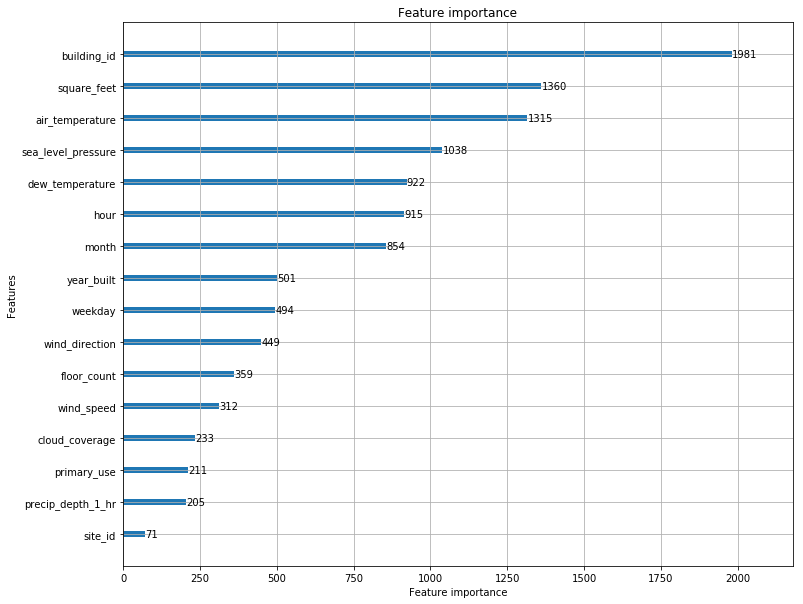

In [59]:
lgb.plot_importance(model_hw[0], max_num_features=20,figsize=(12,10))

In [60]:
# del timestamp hour weekday month as numerical
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.2987565106027472

In [44]:
# del timestamp
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.384161436927704

In [189]:
# weekday in ele
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.27902318009362

In [180]:
# hour as category
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.2826695491418274

In [153]:
# add building median feature
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.3293813224155269

In [87]:
# remove strange data and add hour feature change average method
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.2845213140796496

In [43]:
# five fold
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.1793592428754274

In [19]:
# remove strange data and add hour feature
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.284522580244981

In [65]:
# hour + log square feet feature
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.306757096342972

In [45]:
# hour + weekday feature
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.3276492832153732

In [35]:
# add hour feature
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.3065904018094043

In [15]:
# StratifiedKFold
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

0.7076236766552024

In [61]:
#huber
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.3604628852421023

In [51]:
# rmse
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.352893197767166

In [61]:
sub_all = pd.concat([sub_ele_f,sub_cw_f,sub_stm_f,sub_hw_f])
sub_all.sort_values(by='row_id')

,row_id,meter_reading
0,0,121.746576
1,1,68.518145
2,2,13.683284
3,3,230.797750
4,4,888.581231
...,...,...
41697595,41697595,5.629852
41697596,41697596,4.587675
41697597,41697597,3.875784
41697598,41697598,160.668054


In [47]:
sub_all.loc[sub_all.meter_reading < 0, 'meter_reading'] = 0

In [ ]:
sub_all.to_csv('./data/baseline_delts_num.csv', index = False)

In [27]:
#del sub_all
#gc.collect()

76